# Graph Theoretical Analysis on data collected during POPP experiment on DRD87

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from analysis.sig_proc import Deconvoluter
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/DRD87")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: EPM_NO_OFT_POPP_cellreg_dict.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv
1. full path of: behavior_drd87_POPP.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/behavior_drd87_POPP.csv
2. full path of: EPM_NO_OFT_POPP_centroids.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_centroids.csv
3. full path of: D87_POPP_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_POPP_C_raw.csv
4. full path of: D87_OFT_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_OFT_C_raw.csv
5. full path of: Behavior_DRD87_NO.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_NO.csv
6. full path of: D87_NO_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_NO_C_raw.csv
7. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Raw_EPM2_drd87.csv
8. full path of: Behavior_DRD87_EPM.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_EPM.csv


In [4]:
drd87_raw_data = pd.read_csv(raw_files[3], header=None)
deconvoluter = Deconvoluter(drd87_raw_data)

drd87_behavior = pd.read_csv(raw_files[1])
drd87_behavior.drop(columns=["X center", "Y center", "Area", "Areachange", "Elongation", "Distance moved", "Velocity", "Result 1"], inplace=True)
drd87_behavior.columns = ["Trial Time", "Recording Time", "Arena_centerpoint", "Odor_centerpoint", "Neutral_centerpoint", "Odor_Cup_centerpoint", "Neutral_Cup_centerpoint"]
drd87_behavior = drd87_behavior.assign(Odor_OR_Odor_Cup = drd87_behavior.Odor_centerpoint | drd87_behavior.Odor_Cup_centerpoint)
drd87_behavior = drd87_behavior.assign(Neutral_OR_Neutral_Cup = drd87_behavior.Neutral_centerpoint | drd87_behavior.Neutral_Cup_centerpoint)

drd87 = FeatureExtractor(cell_transients_df=deconvoluter.cell_transients, auc_df=deconvoluter.cell_auc_df, behavior_df=drd87_behavior, row_multiple=2)

# Reindex neuron column vectors from 0, 1, 2, ..., n --> 1, 2, 3, ..., n, n+1
deconvoluter.cell_transients.columns = [col+1 for col in deconvoluter.cell_transients.columns]
deconvoluter.cell_auc_df.columns = [col+1 for col in deconvoluter.cell_auc_df.columns]

# Convert auc dataframe to boolean matrix, where spikes is a 1 and no spike is a 0
drd87.auc_df = drd87.auc_df.where(drd87.auc_df == 0, 1)

#### Read in the cartesian coordinates of the neurons in the DRD87's imaged network of neurons.

In [5]:
coordinates = pd.read_csv("~/Hen_Lab/Mice/DRD87_NO_OFT_POPP_reg/EPM_NO_OFT_POPP_centroids.csv" ,header=None)
coordinates.columns = ['x', 'y']

# Reset the index so that it starts from 1, since we refer to neurons as neurons 1, 2, ..., n
coordinates.index = pd.RangeIndex(1, len(coordinates.index)+1)

#### We use the `get_neuron_positions()` function in order to generate a position dictionary of the cartesian coordinates for each neuron in DRD87's network of neurons. 

In [6]:
def get_neuron_positions(neuron_network, coordinates_df):
    pos = dict()

    for neuron in neuron_network.neurons:
        if neuron not in pos:
            pos[neuron] = (coordinates_df.loc[neuron, :]["x"], -coordinates_df.loc[neuron, :]["y"])
            
    return pos

In [7]:
def get_behavior_graph(feature_extractor, behavior):   
    indices = feature_extractor.neuron_concated_behavior.loc[feature_extractor.neuron_concated_behavior[behavior] != 0].index
    graph = NeuronNetwork(feature_extractor.cell_transients_df.iloc[indices])
    return graph

#### We plot the network of neurons that were imaged in DRD87, for the *entire* duration of the EPM experiment.

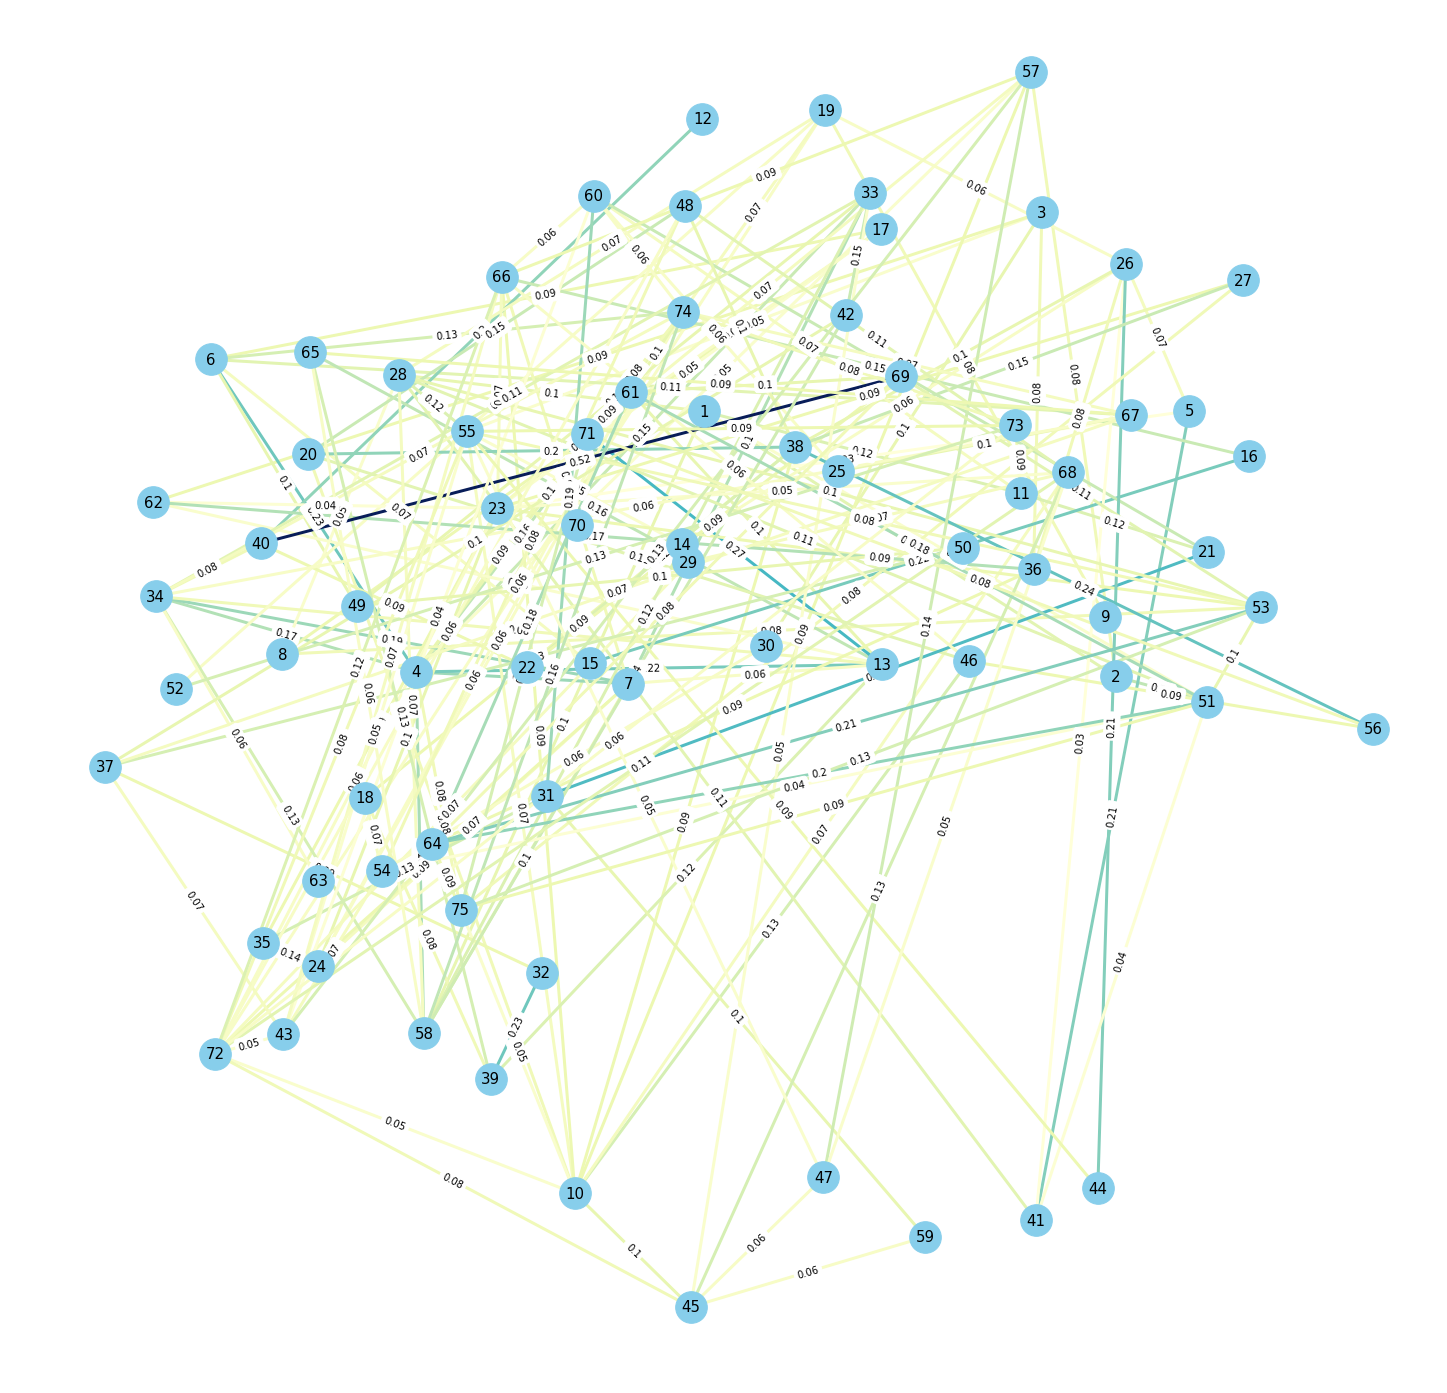

In [8]:
drd87_total_graph = NeuronNetwork(drd87.auc_df)
pos = get_neuron_positions(drd87_total_graph, coordinates)
drd87_total_graph.plot(pos=pos, node_color="skyblue", figsize=(25, 25), node_size=1000)

#### Next, we plot the network of neurons that were imaged in DRD87, for the entire duration of time spent in the **OpenArms** during the EPM experiment.

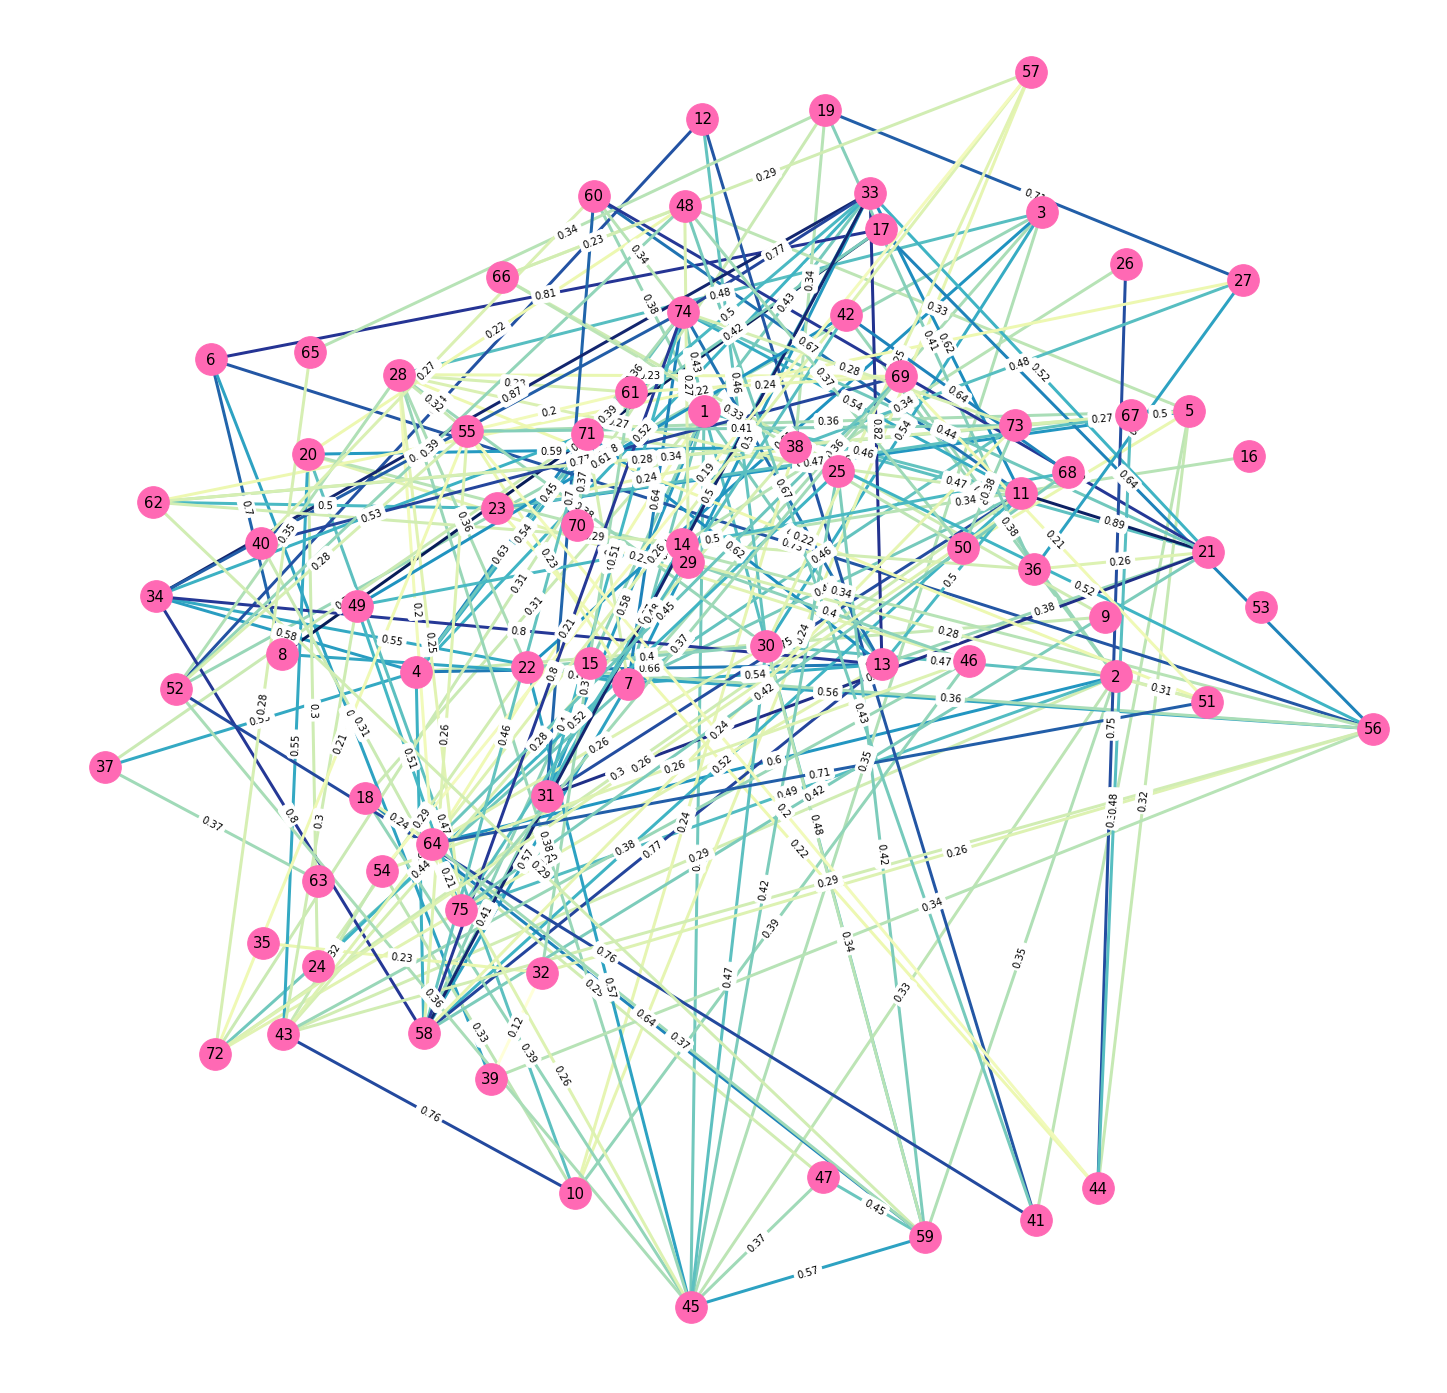

In [9]:
drd87_odor_graph = get_behavior_graph(drd87, "Odor_OR_Odor_Cup")
drd87_odor_graph.plot(pos=pos, node_color="hotpink", figsize=(25, 25), node_size=1000)

#### Finally, we plot the network of neurons that were imaged in DRD87, for the entire duration of time spent in the **ClosedArms** during the EPM experiment.

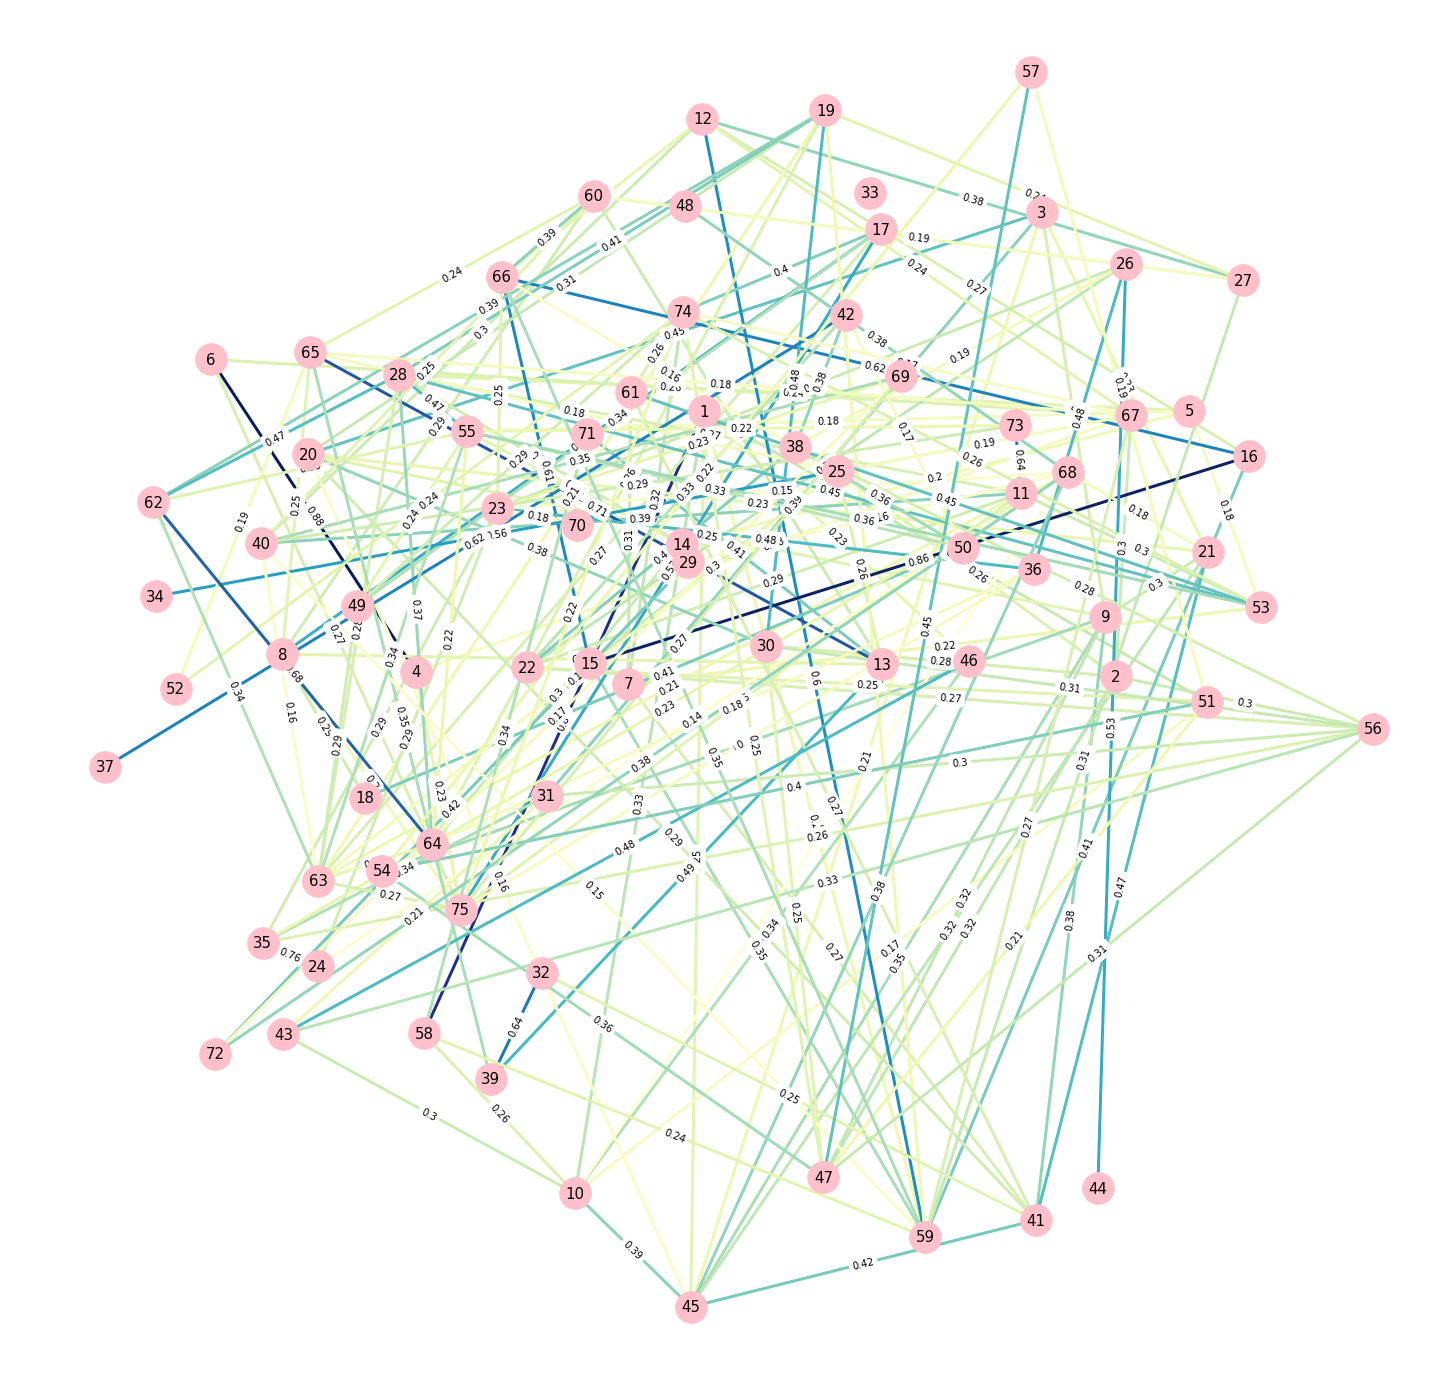

In [10]:
drd87_neutral_graph = get_behavior_graph(drd87, "Neutral_OR_Neutral_Cup")
drd87_neutral_graph.plot(pos=pos, node_color="pink", figsize=(25, 25), node_size=1000)

### Now, we compute and plot all of the network measures (of interest), for each mouse.

In [11]:
import matplotlib.pylab as plt

def quick_bar_plot(y1, y2, **kwargs):
    figsize = kwargs.get("figsize", (6, 5))
    fig, ax = plt.subplots(figsize=figsize)

    index = np.arange(1)
    bar_width = 0.35
    opacity = 0.4
    rects1 = ax.bar(index, tuple(y1), bar_width, alpha=opacity, color='b', label="Odor")
    rects2 = ax.bar(index + bar_width, tuple(y2), bar_width, alpha=opacity, color='r', label="Neutral")

    # ax.set_xlabel("DRD87")
    ylabel = kwargs.get("ylabel", "Measure")
    ax.set_ylabel(ylabel)
    title = kwargs.get("title", "Title Goes Here")
    ax.set_title(title)
    ax.set_xticks([])
    ax.legend();
    fig.tight_layout();
    plt.show();

#### *Hubs are nodes with high degree, or high centrality. The centrality of a node measures how many of the shortest paths between all other nodes pairs in the network pass through it. A node with high centrality is thus cruciail to efficinet communication.* (Bullmore & Sporns, 2009)

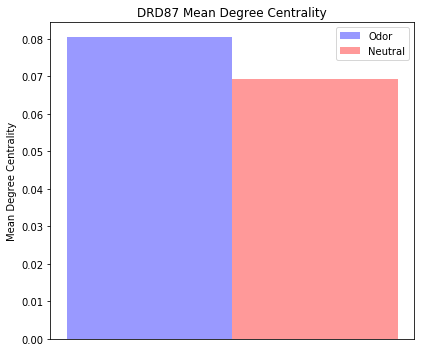

In [12]:
odor_measures = [drd87_odor_graph.mean_degree_centrality] 
neutral_measures = [drd87_neutral_graph.mean_degree_centrality]
quick_bar_plot(odor_measures, neutral_measures, title="DRD87 Mean Degree Centrality", ylabel="Mean Degree Centrality", figsize=(6, 5))

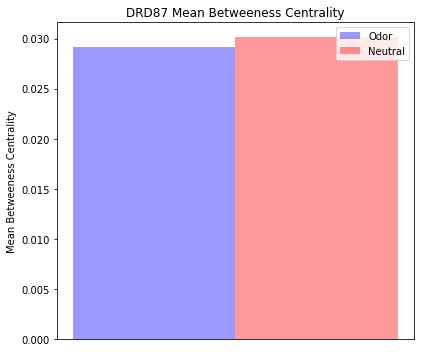

In [13]:
odor_measures = [drd87_odor_graph.mean_betw_centrality] 
neutral_measures = [drd87_neutral_graph.mean_betw_centrality]
quick_bar_plot(odor_measures, neutral_measures, title="DRD87 Mean Betweeness Centrality", ylabel="Mean Betweeness Centrality", figsize=(6, 5))

#### *Connection density is the actual number of edges in the graph as a proportion of the total number of possible edges and is the simplest estimator of the physical cost — for example, the energy or other resource requirements — of a network.* (Bullmore & Sporns, 2009)

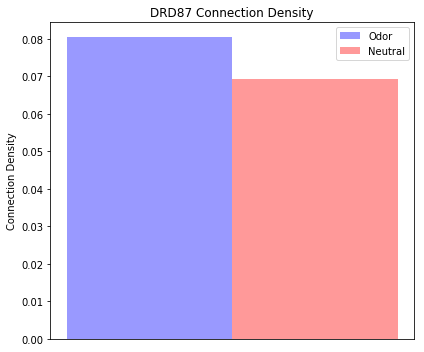

In [14]:
odor_measures = [drd87_odor_graph.connection_density] 
neutral_measures = [drd87_neutral_graph.connection_density]
quick_bar_plot(odor_measures, neutral_measures, title="DRD87 Connection Density", ylabel="Connection Density", figsize=(6, 5))

#### *If the nearest neighbors of a node are also directly connected to each other they form a cluster. The clustering coefficient quantifies the number of connections that exist between the nearest neighbors of a node as a proportion of the maximum number of possible connections. Random networks have lowe average clustering whereas complex networks have high clustering (associated with high local efficiency of information transfer and robustness).* (Bullmore & Sporns, 2009)

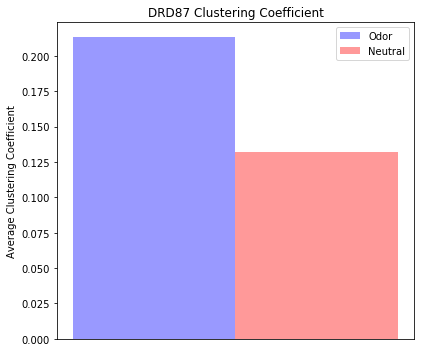

In [15]:
odor_measures = [drd87_odor_graph.clustering_coefficient] 
neutral_measures = [drd87_neutral_graph.clustering_coefficient]
quick_bar_plot(odor_measures, neutral_measures, title="DRD87 Clustering Coefficient", ylabel="Average Clustering Coefficient", figsize=(6, 5))

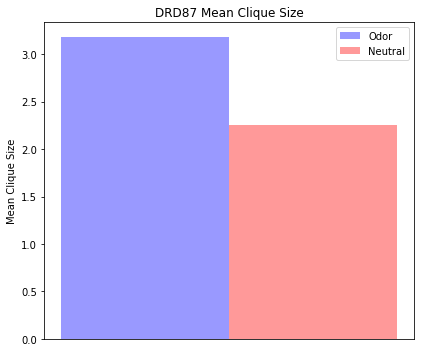

In [16]:
odor_measures = [drd87_odor_graph.mean_clique_size] 
neutral_measures = [drd87_neutral_graph.mean_clique_size]
quick_bar_plot(odor_measures, neutral_measures, title="DRD87 Mean Clique Size", ylabel="Mean Clique Size", figsize=(6, 5))

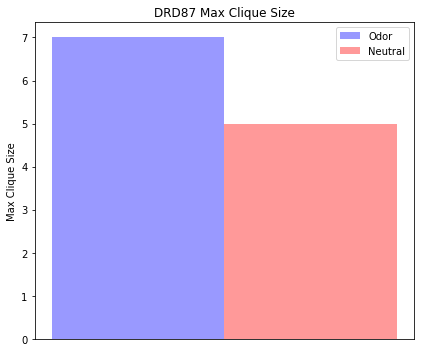

In [17]:
odor_measures = [drd87_odor_graph.max_clique_size] 
neutral_measures = [drd87_neutral_graph.max_clique_size]
quick_bar_plot(odor_measures, neutral_measures, title="DRD87 Max Clique Size", ylabel="Max Clique Size", figsize=(6, 5))

#### *Path length is the minimum number of edges that must be traversed to go from one node to another. Random and complex networks have short mean path lengths (high global efficiency of parallel information transfer) whereas regular lattices have long mean path lengths. Efficiency is inversely related to path length but is numerically easier to use to estimate topological distances between elements of disconnected graphs.* (Bullmore & Sporns, 2009)

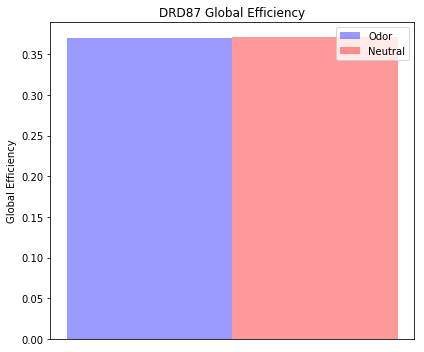

In [18]:
odor_measures = [drd87_odor_graph.global_efficiency] 
neutral_measures = [drd87_neutral_graph.global_efficiency]
quick_bar_plot(odor_measures, neutral_measures, title="DRD87 Global Efficiency", ylabel="Global Efficiency", figsize=(6, 5))

#### Originally described in social networks, the ‘small-world’ property combines high levels of local clustering among nodes of a network (to form families or cliques) and short paths that globally link all nodes of the network. This means that all nodes of a large system are linked through relatively few intermediate steps, despite the fact that most nodes maintain only a few direct connections — mostly within a clique of neighbours. Small-world organization is intermediate between that of random networks, the short overall path length of which is associated with a low level of local clustering, and that of regular networks or lattices, the high-level of clustering of which is accompanied by a long path length. A convenient single-number summary of small-worldness is thus the ratio of the clustering coefficient to the path length after both metrics have been standardized by comparing their values to those in equivalent random networks. (Bullmore & Sporns, 2009)

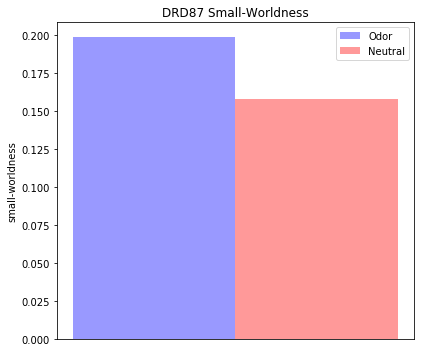

In [19]:
odor_measures = [drd87_odor_graph.small_worldness] 
neutral_measures = [drd87_neutral_graph.small_worldness]
quick_bar_plot(odor_measures, neutral_measures, title="DRD87 Small-Worldness", ylabel="small-worldness", figsize=(6, 5))